In [1]:
import pandahouse as ph
import pandas as pd
import seaborn as sns
import numpy as np
from scipy.stats import  ttest_ind, shapiro, levene, bootstrap, chisquare, chi2_contingency, mannwhitneyu
import pingouin as pg
import matplotlib.pyplot as plt

In [2]:
connection_default = {'host': 'https://clickhouse.lab.karpov.courses',
                      'database':'default',
                      'user':'student', 
                      'password':'dpo_python_2020'
                     }

## Задача 1 А/В тестирование

In [3]:
groups = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-ru-komissarov/Main_project_matireals/Проект_2_groups.csv', sep = ';')
group_add = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-ru-komissarov/Main_project_matireals/Проект_2_group_add.csv', sep = ',')
active_studs = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-ru-komissarov/Main_project_matireals/Проект_2_active_studs.csv')
checks = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-ru-komissarov/Main_project_matireals/Проект_2_checks.csv', sep = ';')

In [4]:
groups # файл с информацией о принадлежности пользователя к контрольной или экспериментальной группе (А – контроль, B – целевая группа) 

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A
...,...,...
74479,5692459,B
74480,5692572,B
74481,5692865,B
74482,5693667,B


In [5]:
groups.dtypes

/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedCacheFailedWarning: Failed to use cache while checking for outdated package.
Set the environment variable OUTDATED_RAISE_EXCEPTION=1 for a full traceback.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.4.0, the latest is 0.5.4.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


id      int64
grp    object
dtype: object

In [6]:
groups.nunique()[0] = groups.id.count()

In [7]:
groups.isnull().sum()

id     0
grp    0
dtype: int64

In [8]:
group_add # дополнительный файл с пользователями, который вам прислали спустя 2 дня после передачи данных.

,id,grp
0,5694584,B
1,5694830,B
2,5695057,B
3,5698872,B
4,5699067,B
...,...,...
87,200247820,B
88,201032527,B
89,201067612,B
90,201067653,B


In [9]:
group_add.dtypes

id      int64
grp    object
dtype: object

In [10]:
group_add.nunique()[0] = group_add.id.count()

In [11]:
group_add.isnull().sum()

id     0
grp    0
dtype: int64

In [12]:
active_studs # файл с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента. 

,student_id
0,581585
1,5723133
2,3276743
3,4238589
4,4475369
...,...
8336,1794344
8337,296883
8338,3598448
8339,3610547


In [13]:
active_studs.dtypes

student_id    int64
dtype: object

In [14]:
active_studs.nunique()[0] = active_studs.student_id.count()

In [15]:
group_add.isnull().sum()

id     0
grp    0
dtype: int64

In [16]:
checks # файл с информацией об оплатах пользователей в дни проведения эксперимента.

,student_id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0
3,26280,690.0
4,100300,990.0
...,...,...
536,5645737,1900.0
537,5651566,1900.0
538,5662322,1900.0
539,5681918,1900.0


In [17]:
checks.dtypes

student_id      int64
rev           float64
dtype: object

In [18]:
checks.nunique()[0] = checks.student_id.count()

In [19]:
checks.isnull().sum()

student_id    0
rev           0
dtype: int64

In [20]:
# Выше была сделана проверка таблиц на соостветсвие нужным типам данных, наличие повторяющихся и пропущенных значений.
# Дубликаты и пропущенные значения не обнаружены, типы данных соответствуют самим данным.

In [21]:
all_groups = pd.concat([groups, group_add])

In [22]:
all_groups

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A
...,...,...
87,200247820,B
88,201032527,B
89,201067612,B
90,201067653,B


In [23]:
all_groups.nunique() # Проверяю наличие дубликатов id в разных таблицах (количество уникальных id совпадает с общим количеством)
# Значит дубликатов нет

id     74576
grp        2
dtype: int64

In [24]:
active_users = all_groups.merge(active_studs, left_on = 'id', right_on = 'student_id')[['student_id', 'grp']]

In [25]:
active_users 
# В дальныейшем все расчеты будем проводить только на пользователях, заходивших на наш сервис в дни проведения эксперимента.
# Поскольку остальные пользователи не пользовались сервисом в дни проведения эксперимента.

,student_id,grp
0,1627,A
1,2085,B
2,2215,B
3,3391,A
4,3401,B
...,...,...
8336,5760471,B
8337,5777081,B
8338,5870856,A
8339,5945085,B


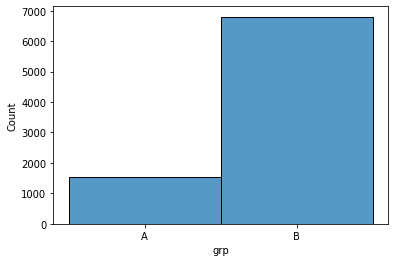

In [26]:
sns.histplot(data = active_users, x = 'grp')

In [27]:
active_users.grp.value_counts()
# Количество пользователей в тестовой группе в день проведения эксперимента преобладает

B    6803
A    1538
Name: grp, dtype: int64

In [28]:
active_paying_users = active_users.merge(checks, on = 'student_id')
# Объединяю таблицу active_users с таблицей checks для получения платящих пользователей вдни проведение эксперимента

In [29]:
active_paying_users
# Количество платящих пользователей не совпадает с количеством пользователей из checks т.к. 
# не все платящие пользователи были участниками эксперимента

,student_id,grp,rev
0,1627,A,990.0000
1,100300,B,990.0000
2,108270,B,290.0000
3,264473,B,1900.0001
4,274352,B,690.0000
...,...,...,...
387,5645737,B,1900.0000
388,5651566,B,1900.0000
389,5662322,B,1900.0000
390,5681918,B,1900.0000


### В качестве первой метрики будет выступать средняя стоимость покупок платящих пользователей из двух групп в дни проведения эксперимента (ARPPU). В этом есть смысл т.к. возможно новая система оплаты позволяет быстрее и удобнее совершить покупку, что может спровоцировать пользователя делать больше покупок или делать их чаще.

In [30]:
median_sum_purchases = active_paying_users.groupby('grp', as_index = False) \
    .agg({'rev': 'median'})
median_sum_purchases

,grp,rev
0,A,585.0
1,B,1140.0


In [31]:
mean_sum_purchases = active_paying_users.groupby('grp', as_index = False) \
    .agg({'rev': 'mean'})
mean_sum_purchases

,grp,rev
0,A,933.589744
1,B,1257.878992


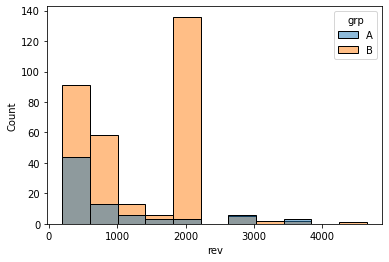

In [32]:
sns.histplot(data = active_paying_users, x = 'rev', hue = 'grp')
# Распределение не является нормальным

In [33]:
active_paying_users['rev_log'] = np.log(active_paying_users.rev)

In [34]:
active_paying_users

,student_id,grp,rev,rev_log
0,1627,A,990.0000,6.897705
1,100300,B,990.0000,6.897705
2,108270,B,290.0000,5.669881
3,264473,B,1900.0001,7.549609
4,274352,B,690.0000,6.536692
...,...,...,...,...
387,5645737,B,1900.0000,7.549609
388,5651566,B,1900.0000,7.549609
389,5662322,B,1900.0000,7.549609
390,5681918,B,1900.0000,7.549609


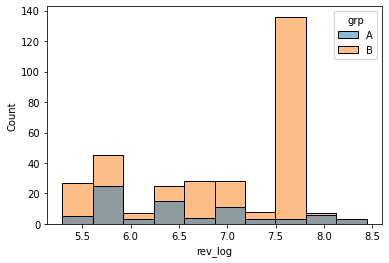

In [35]:
sns.histplot(data = active_paying_users, x = 'rev_log', hue = 'grp')
# Логарифморованное распределение также не является нормальным

In [36]:
shapiro(active_paying_users.query('grp == "B"').rev)

ShapiroResult(statistic=0.8547235727310181, pvalue=1.5437024585965894e-16)

In [37]:
shapiro(active_paying_users.query('grp == "A"').rev)

ShapiroResult(statistic=0.7353236079216003, pvalue=1.4986822893803264e-10)

In [38]:
# Тест shapiro также подтверждает не нормальность распределения

In [39]:
levene(active_paying_users.query('grp == "A"').rev, active_paying_users.query('grp == "B"').rev, center='median')

LeveneResult(statistic=3.075681699981606, pvalue=0.08025675761347022)

#### Тест Шапиро-Уилка показал что распределения далеки от нормального, тест Левена показал гомогенность дисперсий. В принципе, в это случае можно воспользоваться t - тестом т.к. выборки достаточно большие. Но из за большого различия среднего и медианы в контрольной группе велика веротность получения некорректных результатов. Считаю целесообразным воспользоваться методом bootstrap

In [40]:
active_paying_users_test = active_paying_users.query('grp == "B"')

In [41]:
active_paying_users_control = active_paying_users.query('grp == "A"')

In [42]:
n = 10000
medians_control = []
for i in range(n):
    sample_data = active_paying_users_control.sample(frac = 1, replace = True)
    sample_median = sample_data.rev.median()
    medians_control.append(sample_median)
# Создаю список содержащий медианы каждой из 10000 выборок

In [43]:
n = 10000
medians_test = []
for i in range(n):
    sample_data = active_paying_users_test.sample(frac = 1, replace = True)
    sample_median = sample_data.rev.median()
    medians_test.append(sample_median)
# Создаю список содержащий медианы каждой из 10000 выборок.
# Функцию bootstrap не использовал т.к. при расчете тестовой группы выдает ошибку 'Percentiles must be in the range [0, 100]'
# Решение найти не смог

In [44]:
max_control = pd.Series(medians_control).quantile(0.975)
min_control = pd.Series(medians_control).quantile(0.025)
max_test = pd.Series(medians_test).quantile(0.975)
min_test = pd.Series(medians_test).quantile(0.025)
# Расчет доверительных интервалов для каждой группы

In [45]:
results = pd.DataFrame({'grp':['test (B)', 'control (A)'], 
                       'Min':[min_test, min_control],
                       'Max':[max_test, max_control]})

In [46]:
results
# Доверительные интервалы

,grp,Min,Max
0,test (B),990.0,1900.0
1,control (A),398.0,765.0


In [47]:
median_diff = []
for i in range(n):
    sample_data_control = active_paying_users_control.sample(frac = 1, replace = True)
    sample_median_control = sample_data_control.rev.median()
    
    sample_data_exp = active_paying_users_test.sample(frac = 1, replace = True)
    sample_median_exp = sample_data_exp.rev.median()
    
    sample_median_diff = sample_median_exp - sample_median_control
    median_diff.append(sample_median_diff)
# Расчитываю совокупность состоящую из разности медиан

In [48]:
max_diff = pd.Series(median_diff).quantile(0.975)
max_diff
# Верхняя граница разности

1320.0

In [49]:
min_diff = pd.Series(median_diff).quantile(0.025)
min_diff
# Нижняя граница разности

300.0

In [50]:
ttest_ind(active_paying_users_test.rev, active_paying_users_control.rev)

Ttest_indResult(statistic=3.1337795050930985, pvalue=0.0018562025265765867)

In [51]:
mannwhitneyu(active_paying_users_test.rev, active_paying_users_control.rev)
# Ради интереса провел t-тест и тест mannwhitneyu. Оба дали стат значимые результаты

MannwhitneyuResult(statistic=15491.0, pvalue=0.0002511393831406922)

#### В ходе проведение bootstrap теста можно сделать вывод о статистической значимости отличий медиан тестовой и контрольной групп т.к. доверительные интервалы этих медиан не пересекаются и интервал разности этих медиан не содержит в себе 0. Медианная стоимость покупок у тестовой группы значимо увеличилась относительно контрольной.

### В качестве второй метрики использую среднюю сумму покупок всех пользователей заходивших на сервис в дни проведения эксперимента (ARPU)

In [52]:
active_with_rev = active_users.merge(checks, how = 'left', on = 'student_id').fillna(0)
# Создаю датафрейм пользователей со стоимостью покупок, на место пропущенных значений ставлю 0

In [53]:
active_with_rev_test = active_with_rev.query('grp == "B"')
active_with_rev_control = active_with_rev.query('grp == "A"')
# Фильтрую по группам

In [54]:
active_with_rev.groupby('grp', as_index = False) \
    .agg({'rev':'mean'})
# Средние для каждой группы

,grp,rev
0,A,47.347204
1,B,58.058798


In [55]:
active_with_rev.groupby('grp', as_index = False) \
    .agg({'rev':'median'})
# Медианы для каждой группы

,grp,rev
0,A,0.0
1,B,0.0


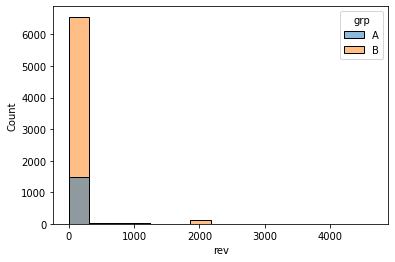

In [56]:
sns.histplot(data = active_with_rev, x = 'rev', hue = 'grp')
# Как видно из гистограммы преобладают пользователи с нулевой суммой покупок

In [57]:
n = 10000
medians_control_1 = []
for i in range(n):
    sample_data = active_with_rev_control.sample(frac = 1, replace = True)
    sample_mean = sample_data.rev.mean()
    medians_control_1.append(sample_mean)
# Создаю список содержащий средние каждой из 10000 выборок

In [58]:
n = 10000
medians_test_1 = []
for i in range(n):
    sample_data = active_with_rev_test.sample(frac = 1, replace = True)
    sample_mean = sample_data.rev.mean()
    medians_test_1.append(sample_mean)
# Создаю список содержащий средние каждой из 10000 выборок

In [59]:
max_control_1 = pd.Series(medians_control_1).quantile(0.975)
min_control_1 = pd.Series(medians_control_1).quantile(0.025)
max_test_1 = pd.Series(medians_test_1).quantile(0.975)
min_test_1 = pd.Series(medians_test_1).quantile(0.025)
# Расчет доверительных интервалов для каждой группы

In [60]:
results_1 = pd.DataFrame({'grp':['test (B)', 'control (A)'], 
                       'Min':[min_test_1, min_control_1],
                       'Max':[max_test_1, max_control_1]})

In [61]:
results_1

,grp,Min,Max
0,test (B),50.691989,65.516655
1,control (A),33.764321,62.583956


In [62]:
median_diff_1 = []
for i in range(n):
    sample_data_control = active_with_rev_control.sample(frac = 1, replace = True)
    sample_mean_control = sample_data_control.rev.mean()
    
    sample_data_exp = active_with_rev_test.sample(frac = 1, replace = True)
    sample_mean_exp = sample_data_exp.rev.mean()
    
    sample_mean_diff = sample_mean_exp - sample_mean_control
    median_diff_1.append(sample_mean_diff)
# Расчитываю совокупность состоящую из разности медиан

In [63]:
max_diff_1 = pd.Series(median_diff_1).quantile(0.975)
max_diff_1
# Верхняя граница разности

26.152614634187625

In [64]:
min_diff_1 = pd.Series(median_diff_1).quantile(0.025)
min_diff_1
# Нижняя граница разности

-6.208979592095059

In [65]:
# bootstrap показал что стат значимых различий нет так как доверительные интервалы пересекаются и интервал разностей содержит 0
# В bootstrap использовал средние значения так как медианы этих выборок всегда равняются нулю 
# из за большого преобладания пользователей с нулевой суммой покупок

In [66]:
ttest_ind(active_with_rev_test.rev, active_with_rev_control.rev)

Ttest_indResult(statistic=1.2253411073793445, pvalue=0.22048133326988378)

In [67]:
mannwhitneyu(active_with_rev_test.rev, active_with_rev_control.rev)

MannwhitneyuResult(statistic=5210901.0, pvalue=0.5099747992861601)

In [68]:
# t-тест и непараметрический критерий Манна - Уитни также не дали статистически значимого результата

#### В ходе проведение различных тестов делаю вывод об отсутствии статистически значимых отличий средних сумм покупок в выборках из всех пользователей двух групп заходивших на сервис в дни проведения эксперимента

### В качестве следующего критерия я предлагаю рассмотреть конверсию пользователей в покупку (CR), так как рост этого показателя является одно из целей нововведений в системе оплаты. Для сравнения конверсий буду использовать хи квадрат т.к. конверсия является категориальной переменной

In [69]:
active_with_rev

,student_id,grp,rev
0,1627,A,990.0
1,2085,B,0.0
2,2215,B,0.0
3,3391,A,0.0
4,3401,B,0.0
...,...,...,...
8336,5760471,B,0.0
8337,5777081,B,0.0
8338,5870856,A,0.0
8339,5945085,B,0.0


In [70]:
paid = []
for i in active_with_rev.rev:
    if i > 0:
        paid.append('paid')
    else:
        paid.append('not_paid')
# Для каждого записи присваиваю paid для совершивших покупку, not_paid для не совершивших покупку и кладу их в список paid

In [71]:
active_with_rev['paid'] = paid
# Добавляю этот список в датафрейм

In [72]:
active_with_rev = active_with_rev[['student_id', 'grp', 'rev', 'paid']]

In [73]:
stuents_count = active_with_rev.groupby(['grp', 'paid'], as_index = False).agg({'student_id':'count'})
stuents_count
# Группирую по полям grp и paid и считаю количество id 

,grp,paid,student_id
0,A,not_paid,1460
1,A,paid,78
2,B,not_paid,6489
3,B,paid,314


In [74]:
pivot_stuents_count = stuents_count.pivot(columns = 'grp', index = 'paid', values = 'student_id')
pivot_stuents_count
# Из полученной таблицы делаю сводную таблицу

grp,A,B
paid,,
not_paid,1460,6489
paid,78,314


In [75]:
cr_control = stuents_count.student_id[1] / stuents_count.student_id[0]
cr_control
# Расчет конверсии в контрольной группе

0.05342465753424658

In [76]:
cr_test = stuents_count.student_id[3] / stuents_count.student_id[2]
cr_test
# Расчет конверсии в тестовой группе

0.04838958237016489

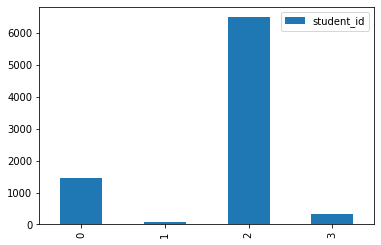

In [77]:
stuents_count.plot.bar()

In [78]:
chi2_contingency(pivot_stuents_count, correction=False)[1]
# Расчитываю хи квадрат, на выходе получаю p-value

0.44547028437158964

#### Исходя из проведенного теста по критерию хи квадрат можно сделать вывод о том, что конверсии двух групп имеют относительно одиннаковые распределения (p>0.05). Значит нововведения не повлияли на конверсию пользователей в покупку

### Вывод:                                                                                                                                                                             Из трех проанализированных критериев статистически значимые отличия в лучшую сторону имеет лишь сумма покупок платящих пользователей учавствовавших в эксперименте (ARPPU), остальные метрики не показали значимых отличий. 
### Я прелагаю начать использовать новую механнику оплаты на сервисе в качестве основной, несмотря на то что положительные изменения показала только одна метрика. Другие метрики не показали значимых ухудшений

## Задача 2.1 Очень усердные ученики

In [79]:
table1 = """
select
    count(st_id) as count_st_id
from
(
select
    st_id,
    count(correct) as count_correct
from peas
where correct = 1 and month(timest) = (select max(month(timest)) from peas)
group by st_id
having count(correct) >= 20
) as t
"""
# Группирую таблицу default.peas по полю st_id, считаю количество правильно решенных горошин для каждого id. 
# Фильтрую по полю correct оставляя только те записи, значения которых равны 1 
# и по полю timest оставляя записи за последний месяц (это не обязательно так как все записи данной таблице соостветсвуют одному месяцу).

task_2_1 = ph.read_clickhouse(query=table1, connection=connection_default)
task_2_1

,count_st_id
0,136


## Задача 2.2 Оптимизация воронки

In [80]:
table2 = '''
with 
active_users as
(
select
    test_grp,
    count(st_id) as active_users
from
(
select
    st_id,
    count(correct) as count_correct
from peas
where correct = 1
group by st_id
having count(correct) > 10
) as t1
    join studs as t2 using(st_id)
group by test_grp
)

, active_math_users as
(
select
    test_grp,
    count(t4.st_id) as active_math_users,
    count(t4.st_id) filter (where money > 0) as active_paying_math_users
from
(
select
    st_id,
    count(correct) as count_correct_math
from peas
where correct = 1 and subject = 'Math'
group by st_id
having count(correct) >= 2
) t4 
    join studs as t5 using(st_id)
    left join (select subject, st_id, money from default.final_project_check where subject = 'Math') as t8 on t4.st_id = t8.st_id
group by test_grp
)

select
    t.test_grp as test_grp,
    round(revenue / count_id, 2) as arpu,
    round(revenue / count_paying_id, 2) as arpau,
    concat(cast(round(count_paying_id * 100 / count_id, 2) as varchar), ' ', '%') as cr,
    concat(cast(round(count_paying_id * 100 / active_users, 2) as varchar), ' ', '%') as cr_active_users,
    concat(cast(round(active_paying_math_users * 100 / active_math_users, 2) as varchar), ' ', '%') as cr_active_math_users
from
(
select
    test_grp,
    sum(money) as revenue,
    count(distinct st_id) as count_id,
    count(distinct st_id) filter (where money > 0) as count_paying_id
from studs as l
    left join (select st_id, money, subject from final_project_check) as r using(st_id)
group by test_grp
) as t
    join active_users as t6 using(test_grp)
    join active_math_users as t7 on t.test_grp = t7.test_grp
'''
# В блок with я поместил две таблицы
# 1.Таблица active_users - расчет количества активных полозователей в каждой группе.
# Для получения этой таблицы я сгруппировал данные по полю st_id и посчитал количество correct со значением 1 для каждого id
# после группировке в блоке having оставел только те записи у которых значения оказались больше 10.
# Далее я сджойнил получившуюся таблице с таблицей studs для получения информации о пренадлежнасти каждого id к группе control или pilot
# После это для каждой группы посчитал количество st_id

# 2.Таблица active_math_users - расчет количество активных пользователей по математике в каждой группе.
# Запрос для получения этой таблицы похож на предыдущий за исключением столбца active_paying_math_users.
# Для его получения я левым джойном присоеденил заранее отфильтрованную таблицу final_project_check для получения информации о пользователях купивших курс по математике.
# Далее посчитал количество st_id у которых был зафиксирован факт покупки курса.

# Для расчета arpu, arpau, и cr я таблицу studs сджойнил с таблицей final_project_check.
# Далее посчитал суммарную выручку, количество уникальных st_id и st_id совершивших покупку в каждой группе.
# Далее получившуюся таблицу сджойнил с таблицами из блока with и посчитал требуемые по заданию метрики.

task_2_2 = ph.read_clickhouse(query=table2, connection=connection_default)
task_2_2

,test_grp,arpu,arpau,cr,cr_active_users,cr_active_math_users
0,control,4540.98,92333.33,4.92 %,11.81 %,6.12 %
1,pilot,11508.47,106093.75,10.85 %,33.33 %,9.52 %


## Задание 3. Python

### Задача 3.1

In [81]:
def update_df(original_df, new_df):
    # Переименовываю название столбцов второго датафрейма в названия первого
    new_df = new_df.rename(columns = {new_df.columns[0]:original_df.columns[0], 
                                         new_df.columns[1]:original_df.columns[1]})
    # Последовательно соединяю таблицы
    full_data = pd.concat([original_df, new_df])
    
    # Таблица активных пользователей
    active_users_data = full_data.merge(active_studs, left_on = 'id', right_on = 'student_id')[['student_id', 'grp']]
    
    # Таблица для ARPPU
    active_paying_users_data = active_users_data.merge(checks, on = 'student_id')
    
    # Расчет ARPPU
    group_a_arppu = active_paying_users_data.query('grp == "A"')
    group_b_arppu = active_paying_users_data.query('grp == "B"')
    arppu_a = round(group_a_arppu.rev.sum() / group_a_arppu.rev.size, 2)
    arppu_b = round(group_b_arppu.rev.sum() / group_b_arppu.rev.size, 2)
    
    # Таблица для ARPU
    active_users_data_with_rev = active_users_data.merge(checks, how = 'left', on = 'student_id').fillna(0)
    
    # Расчет ARPU
    group_a_arpu = active_users_data_with_rev.query('grp == "A"')
    group_b_arpu = active_users_data_with_rev.query('grp == "B"')
    arpu_a = round(group_a_arpu.rev.sum() / group_a_arpu.rev.size, 2)
    arpu_b = round(group_b_arpu.rev.sum() / group_b_arpu.rev.size, 2)
    
    # Расчет CR в покупку
    paid = []
    for i in active_users_data_with_rev.rev:
        if i > 0:
            paid.append('paid')
        else:
            paid.append('not_paid')
    active_users_data_with_rev_cr = active_users_data_with_rev.copy()
    active_users_data_with_rev_cr['paid'] = paid
    users_count = active_users_data_with_rev_cr.groupby(['grp', 'paid'], as_index = False).agg({'student_id':'count'})
    cr_pay_control = round(users_count.student_id[1] * 100 / users_count.student_id[0], 2)
    cr_pay_test = round(users_count.student_id[3] * 100 / users_count.student_id[2], 2)
    
    # Функция будет возвращать датафрейм
    return pd.DataFrame({'grp': ['Control(A)', 'Test(B)'],
            'arppu': [arppu_a, arppu_b],
            'arpu': [arpu_a, arpu_b],
            'cr %': [cr_pay_control, cr_pay_test]})    

In [82]:
update_df(groups, group_add)

,grp,arppu,arpu,cr %
0,Control(A),933.59,47.35,5.34
1,Test(B),1257.88,58.06,4.84


### Задача 3.2

In [83]:
# Функция для вывода гистограмм
def histogram(df_with_metrics):
    plt.rcParams["figure.figsize"] = (10,8)
    update_df(groups, group_add).plot.bar(x = 'grp', y = 'arppu')
    update_df(groups, group_add).plot.bar(x = 'grp', y = 'arpu')
    update_df(groups, group_add).plot.bar(x = 'grp', y = 'cr %')

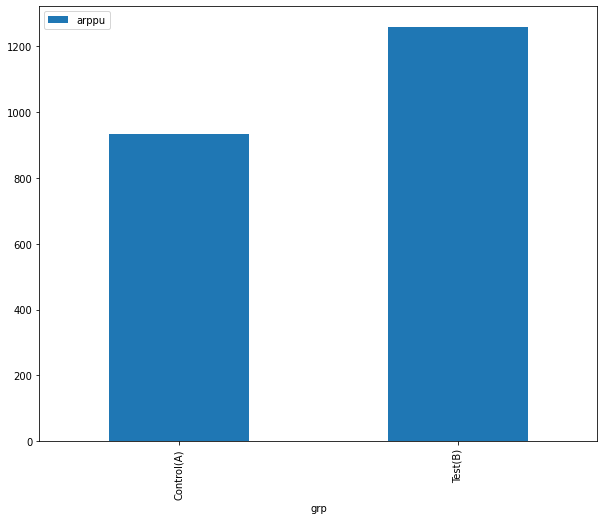

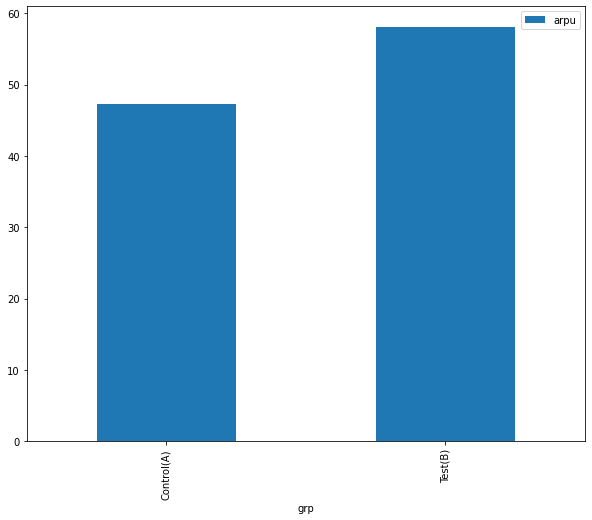

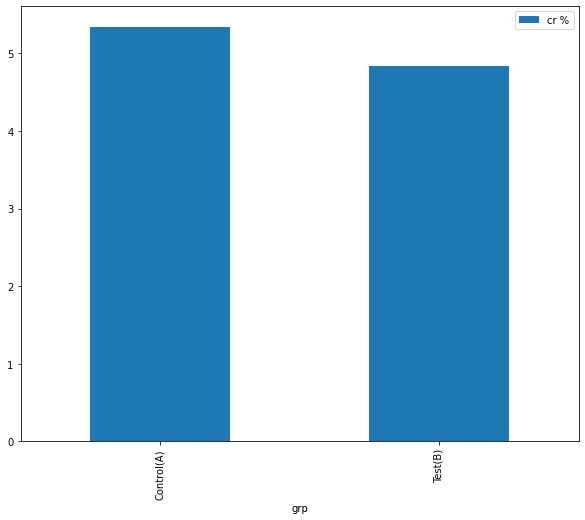

In [84]:
histogram(update_df(groups, group_add))